**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

Cameras create image distortions when transforming 3D objects in the real world into a 2D images.  Image distortions cause the following problems.
- Can change the apparent size of an object in an image
- Can change the apparent shape of an object in an image
- Can cause an object's appearance to change depending on where it is in the field of view
- Can make object appears appear closer or farther away than they actually are


The first step is undistort the images so that you can get accurate and useful information out of them.  The function get_objpoints_and_imgpoints computes object points and image points from a collection of chessboard images. I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.    

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

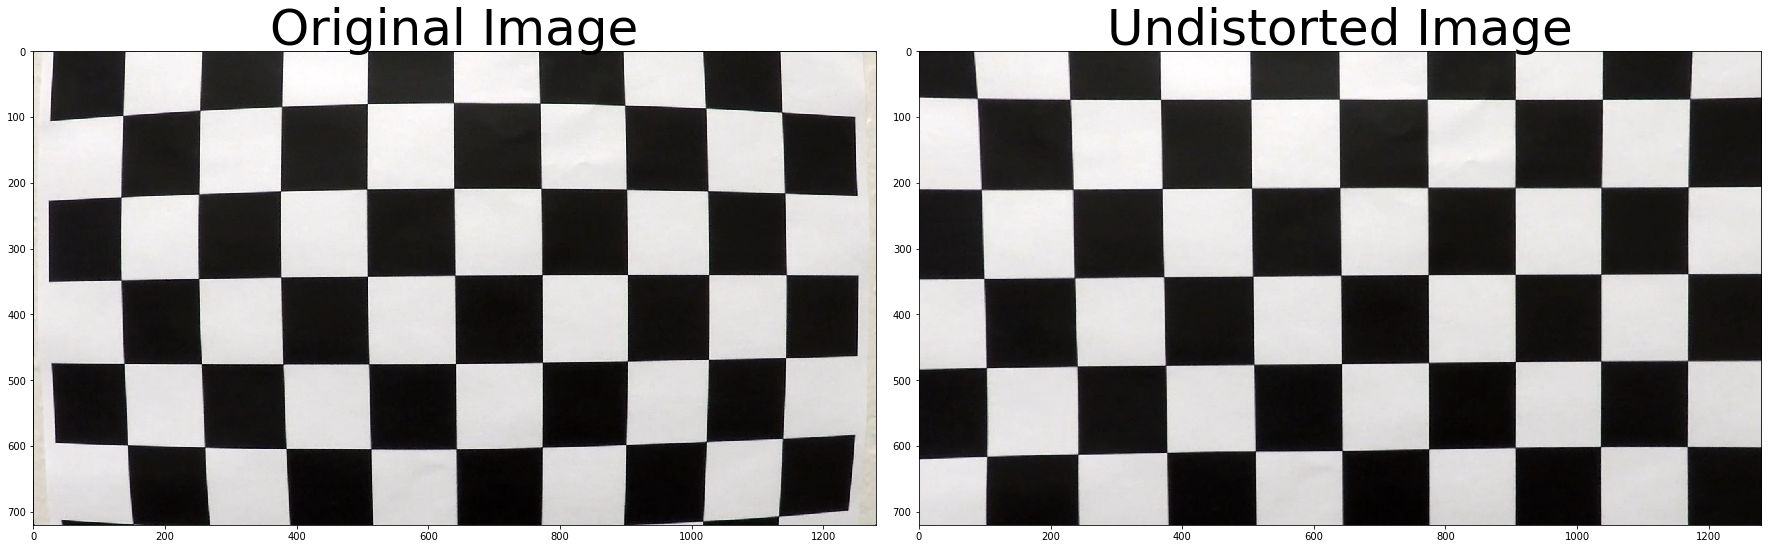

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from helper_functions import *
    
nx=9
ny=6
calibration_images = glob.glob("camera_cal/calibration*.jpg")
objpoints, imgpoints = get_objpoints_and_imgpoints(calibration_images, nx, ny)


# Test undistortion on an image
img = mpimg.imread(calibration_images[0])
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

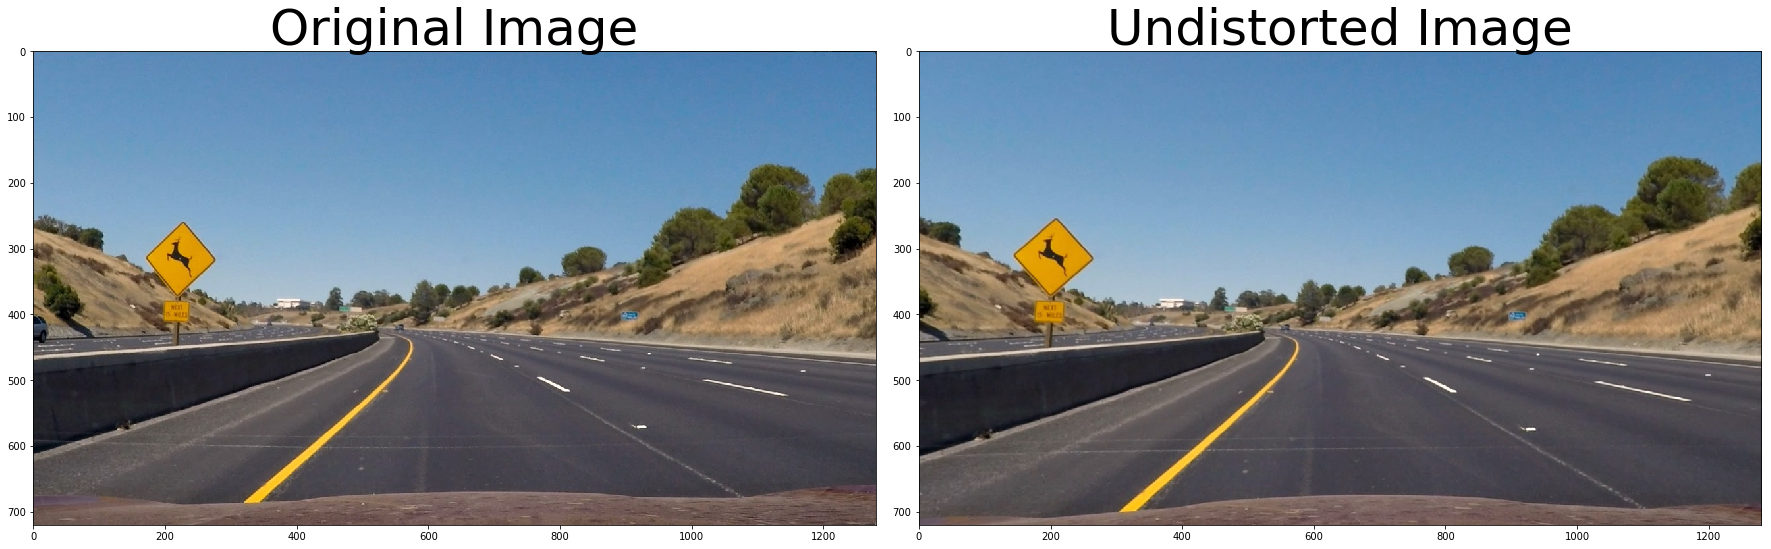

In [2]:
test_images = glob.glob("test_images//*.jpg")

img = mpimg.imread(test_images[3])
undistorted = cal_undistort(img, objpoints, imgpoints)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.  

The previous lane finding project used Canny edge detection to detect lines in an image.  However, this method gave us a lot of lines from scenery, cars, and other objects that we ended up discarding.  We know that lane lines are close to vertical and have white and yellow color.  This information helps us create smarter gradients and color transforms that detect fewer unnecessary lines.  The get_combined_mask uses a combination of color and gradient thresholds to generate a binary image.  Here's an example of my output for this step.  

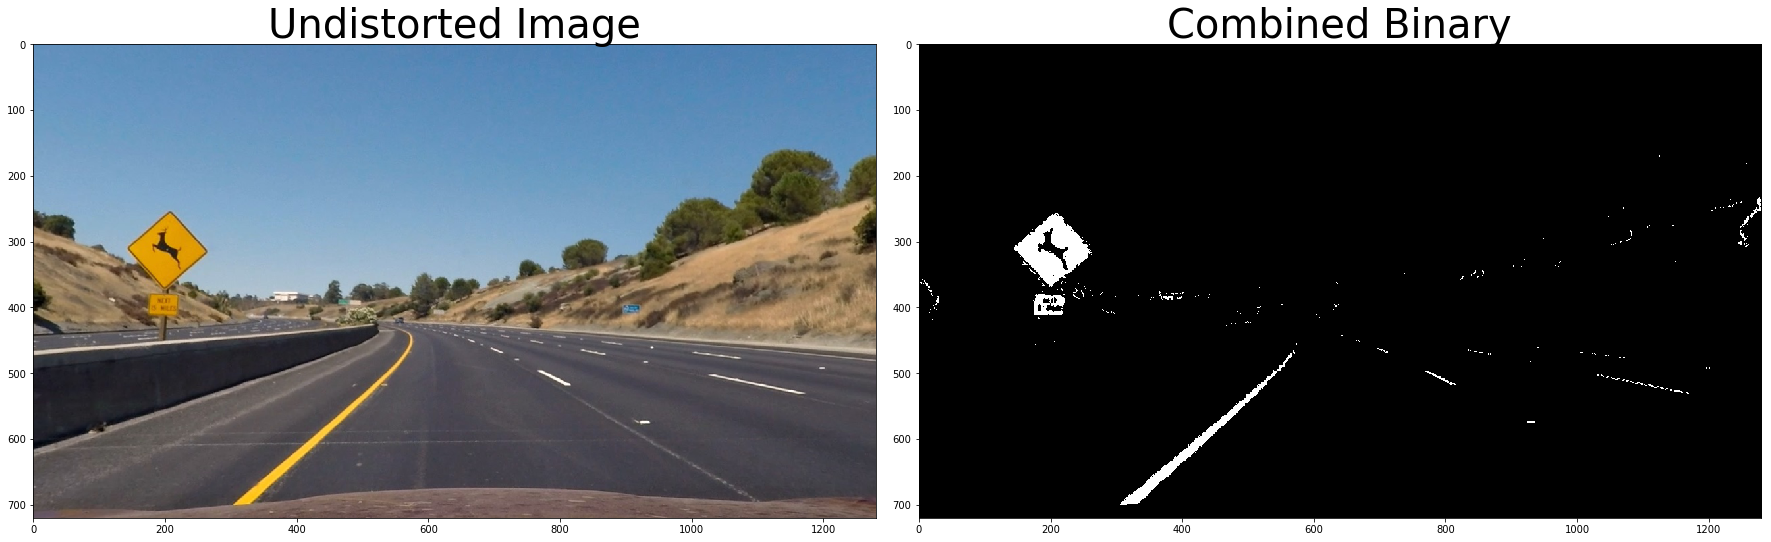

In [3]:
combined_binary = get_combined_mask(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=40)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined Binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

A perspective transform maps the points in a given image to different, desired, image points with a new perspective.  The code for my perspective transform includes a function called warper(), which appears in helper_functions.py. The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points. The source and destination points are computed based on the image size using the get_src_and_dst method.  

The code below performs a bird’s-eye view transform of the image.  It verifies that my perspective transform was working as expected by drawing the src and dst points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.  This transformation allows us to see the lane from above which is useful for calculating the lane curvature.

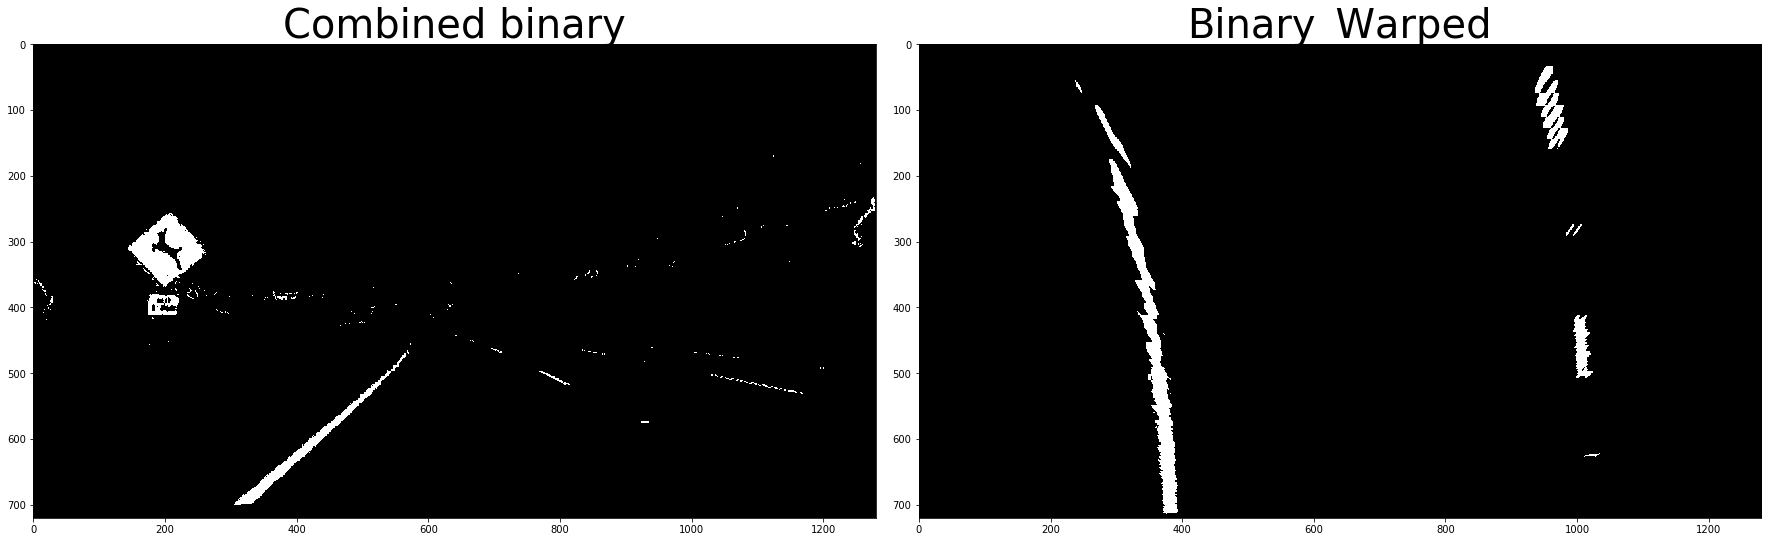

In [4]:
src, dst = get_src_and_dst(combined_binary)

binary_warped = warper(combined_binary, src, dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Combined binary', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary_Warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

The find_window_pixels function does the following:
- compute a histogram along all the columns in the lower half of the image
- add up the pixel values along each column in that histogram 
- pixel values in binary image are either 0 or 1
- two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines
- use that as a starting point for where to search for the lines
- use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame


Stop using the find_window_pixels method once you know where the lines are.  In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous line position using the find_pixels function.  

In [5]:
leftx, lefty, rightx, righty = find_window_pixels(binary_warped)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The radius_of_curvature function computes the left_curverad, right_curverad based on which pixels belong to the left and right lane lines.  The function vehicle_center computes the position of the vehicle with respect to the center.  

In [6]:
from helper_functions import *
left_curverad, right_curverad = radius_of_curvature(binary_warped, leftx, lefty, rightx, righty)
curvature_text = "L Curverad: {0:.0f}, R Curverad: {0:.0f}".format(left_curverad, right_curverad)
print(curvature_text)

center = vehicle_center(binary_warped, leftx, lefty, rightx, righty)
center_text = "Center: {0:.2f}m".format(center)
print(center_text)


L Curverad: 2240, R Curverad: 2240
Center: -0.28m


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

The function region_of_interest draws the color mask of the lane.  The color mask is unwarped and then projected back to the original image.    

In [8]:
def process_image(img):
    global leftx, lefty, rightx, righty
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combined_binary = get_combined_mask(undistorted)
    src, dst = get_src_and_dst(combined_binary)
    binary_warped = warper(combined_binary, src, dst)

    if len(leftx) == len(lefty) == len(rightx) == len(righty) > 0:
        leftx, lefty, rightx, righty = find_pixels(
            binary_warped, leftx, lefty, rightx, righty)
    else:
        leftx, lefty, rightx, righty = find_window_pixels(binary_warped)

    left_curverad, right_curverad = radius_of_curvature(
        binary_warped, leftx, lefty, rightx, righty)
    curvature_text = "L Curverad: {0:.0f}, R Curverad: {0:.0f}".format(
        left_curverad, right_curverad)

    center = vehicle_center(binary_warped, leftx, lefty, rightx, righty)
    center_text = "Center {0:.2f}".format(center)

    color_warp = region_of_interest(
        binary_warped, leftx, lefty, rightx, righty)
    newwarp = warper(color_warp, dst, src)

    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, curvature_text, (50, 50), font, 1, (255, 255, 255), 2)
    cv2.putText(result, center_text, (50, 100), font, 1, (255, 255, 255), 2)

    return result

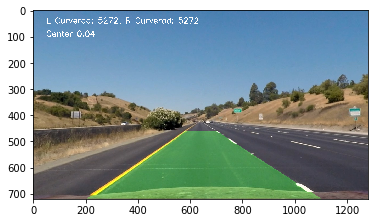

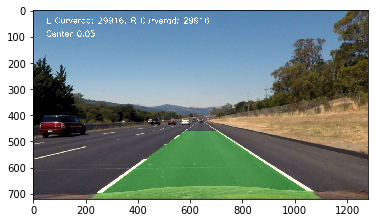

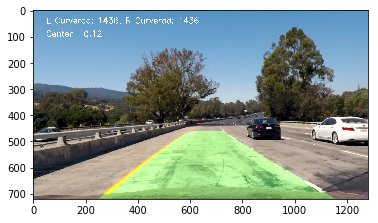

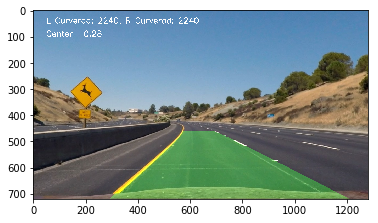

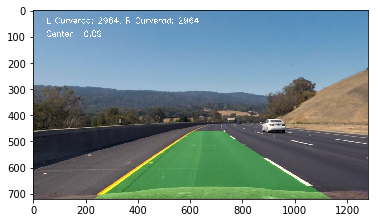

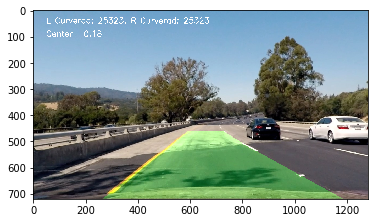

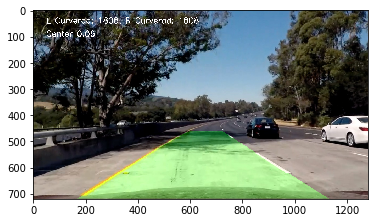

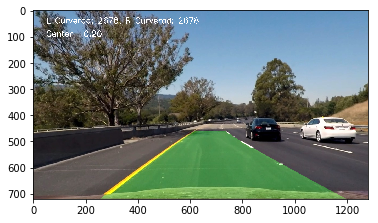

In [9]:
for test_image in test_images:
    image = img = mpimg.imread(test_image)
    output_image = process_image(image)
    plt.imshow(output_image)
    plt.show()   

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

The process_image function puts together all the steps I described above to be used for a video.  Here's a [link to my video result](./output.mp4) 

In [10]:
leftx = []
lefty = []
rightx = []
righty = []

if 1 + 1 == 2:
    video = VideoFileClip("project_video.mp4")
    project_clip = video.fl_image(process_image) 
    video_output = "output.mp4"
    %time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [18:15<00:00,  1.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 18min 37s, sys: 51.1 s, total: 19min 28s
Wall time: 18min 17s


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The pipeline seems fairly robust.  I combined the image pipeline in class with a color mask.  The color mask is used to get yellow and white pixel.  The image pipeline in class had trouble with shadows.  The color mask didn't give very good lane lines.  Combining the two worked really.  The algorithm is really slow.  The speed could be improved.  I would like to try a CNN but I don't have a labeled dataset.    